## Лабораторная работа №8 (Проведение исследований моделями обнаружения и распознавания объектов)

### 1. Выбор начальных условий

#### 1.a Выбор набора данных

**Источник и структура:**  
- **Название:** MASATI-V2 (Boat Detection in Satellite Imagery)  
- **Где найти:** Kaggle – https://www.kaggle.com/datasets/louisaberdeen/masati-v2
- **Описание:** Этот датасет состоит из 4 522 размеченных спутниковых снимков океана и прибрежной зоны, где каждый корабль или лодка обведены bounding box
- **Аннотации:** готовые `.txt`-файлы в формате YOLO — каждая строка: `class x_center y_center width height` (в нормализованных координатах)  
- **Класс объектов (1):** `boat`  
- **Размер выборки и сплит:** 4 522 изображения, уже разделённые на `train` / `val` / `test`  
- **Разрешение:** в среднем ≈ 512 × 512 пикселей

**Практическая значимость:**  
1. **Морская безопасность и береговая охрана**  
 - Автоматизированное обнаружение судов в прибрежных зонах повышает эффективность патрулирования и снижает риски нелегальной деятельности.  
2. **Противодействие браконьерству и пиратству**  
 - Своевременная детекция лодок в заповедных морских зонах помогает предотвращать незаконный промысел и акты пиратства.  
3. **Поиск и спасение (SAR)**  
 - Ускоренное обнаружение терпящих бедствие судов сокращает время реакции спасательных служб и повышает шансы на успешную операцию.  
4. **Управление портовой инфраструктурой и логистика**  
 - Подсчёт и классификация судов в порту оптимизируют график швартовки и разгрузки, способствуя более эффективной работе портов.  
5. **Экологический мониторинг**  
 - Отслеживание движения судов помогает оценить риски загрязнения воды и планировать превентивные меры.


In [1]:
# Cell 0 — Устанавливаем библиотеки
!pip install ultralytics kaggle opencv-python -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.0 MB/s eta 0:00:00


In [2]:
# Cell 1 — Импортируем основные модули
import os
import cv2
import torch
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Удаляем старый датасет и архив, если они есть
!rm -rf /content/masati
!rm -f masati-v2.zip

In [4]:
# Cell 2 — Загрузка kaggle.json
from google.colab import files

uploaded = files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [5]:
# Cell 3 — Скачиваем и распаковываем
!kaggle datasets download louisaberdeen/masati-v2
!unzip -q masati-v2.zip -d /content/masati



Dataset URL: https://www.kaggle.com/datasets/louisaberdeen/masati-v2
License(s): other


In [6]:
# Cell 4 — Собираем пути к изображениям и разметке (ленивая загрузка)
import os

# Пути к папкам с train-изображениями и разметкой
BASE_IMAGE_PATH  = "/content/masati/MASATI/output/train/images"
BASE_LABELS_PATH = "/content/masati/MASATI/output/train/labels"

# Собираем полный список путей к изображениям
image_paths = sorted([
    os.path.join(BASE_IMAGE_PATH, f)
    for f in os.listdir(BASE_IMAGE_PATH)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
])

# Для каждого изображения генерируем соответствующий путь к .txt
label_paths = [
    os.path.join(BASE_LABELS_PATH, os.path.splitext(os.path.basename(p))[0] + ".txt")
    for p in image_paths
]

print(f"Найдено {len(image_paths)} train-изображений")

Найдено 3617 train-изображений


In [1]:
# Cell 4 — Читаем изображения и строим бинарные маски из YOLO-разметки
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.io import read_image

BASE_IMAGE_PATH  = "/content/masati/MASATI/output/train/images"
BASE_LABELS_PATH = "/content/masati/MASATI/output/train/labels"

image_data   = []
image_masks  = []

image_files = sorted([
    f for f in os.listdir(BASE_IMAGE_PATH)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
])
image_count = len(image_files)
print(f"Найдено {image_count} train-изображений")

for fname in image_files:
    img_path = os.path.join(BASE_IMAGE_PATH, fname)
    img = read_image(img_path)            # Tensor [C, H, W]
    image_data.append(img)

    _, H, W = img.shape
    mask = torch.zeros((H, W), dtype=torch.float32)

    lbl_path = os.path.join(BASE_LABELS_PATH, os.path.splitext(fname)[0] + ".txt")
    with open(lbl_path, "r") as f:
        for line in f:
            cls, xc, yc, bw, bh = map(float, line.strip().split())
            x1 = int((xc - bw/2) * W)
            y1 = int((yc - bh/2) * H)
            x2 = int((xc + bw/2) * W)
            y2 = int((yc + bh/2) * H)
            mask[y1:y2, x1:x2] = 1.0

    image_masks.append(mask)


Загружено 3617 изображений и 3617 масок


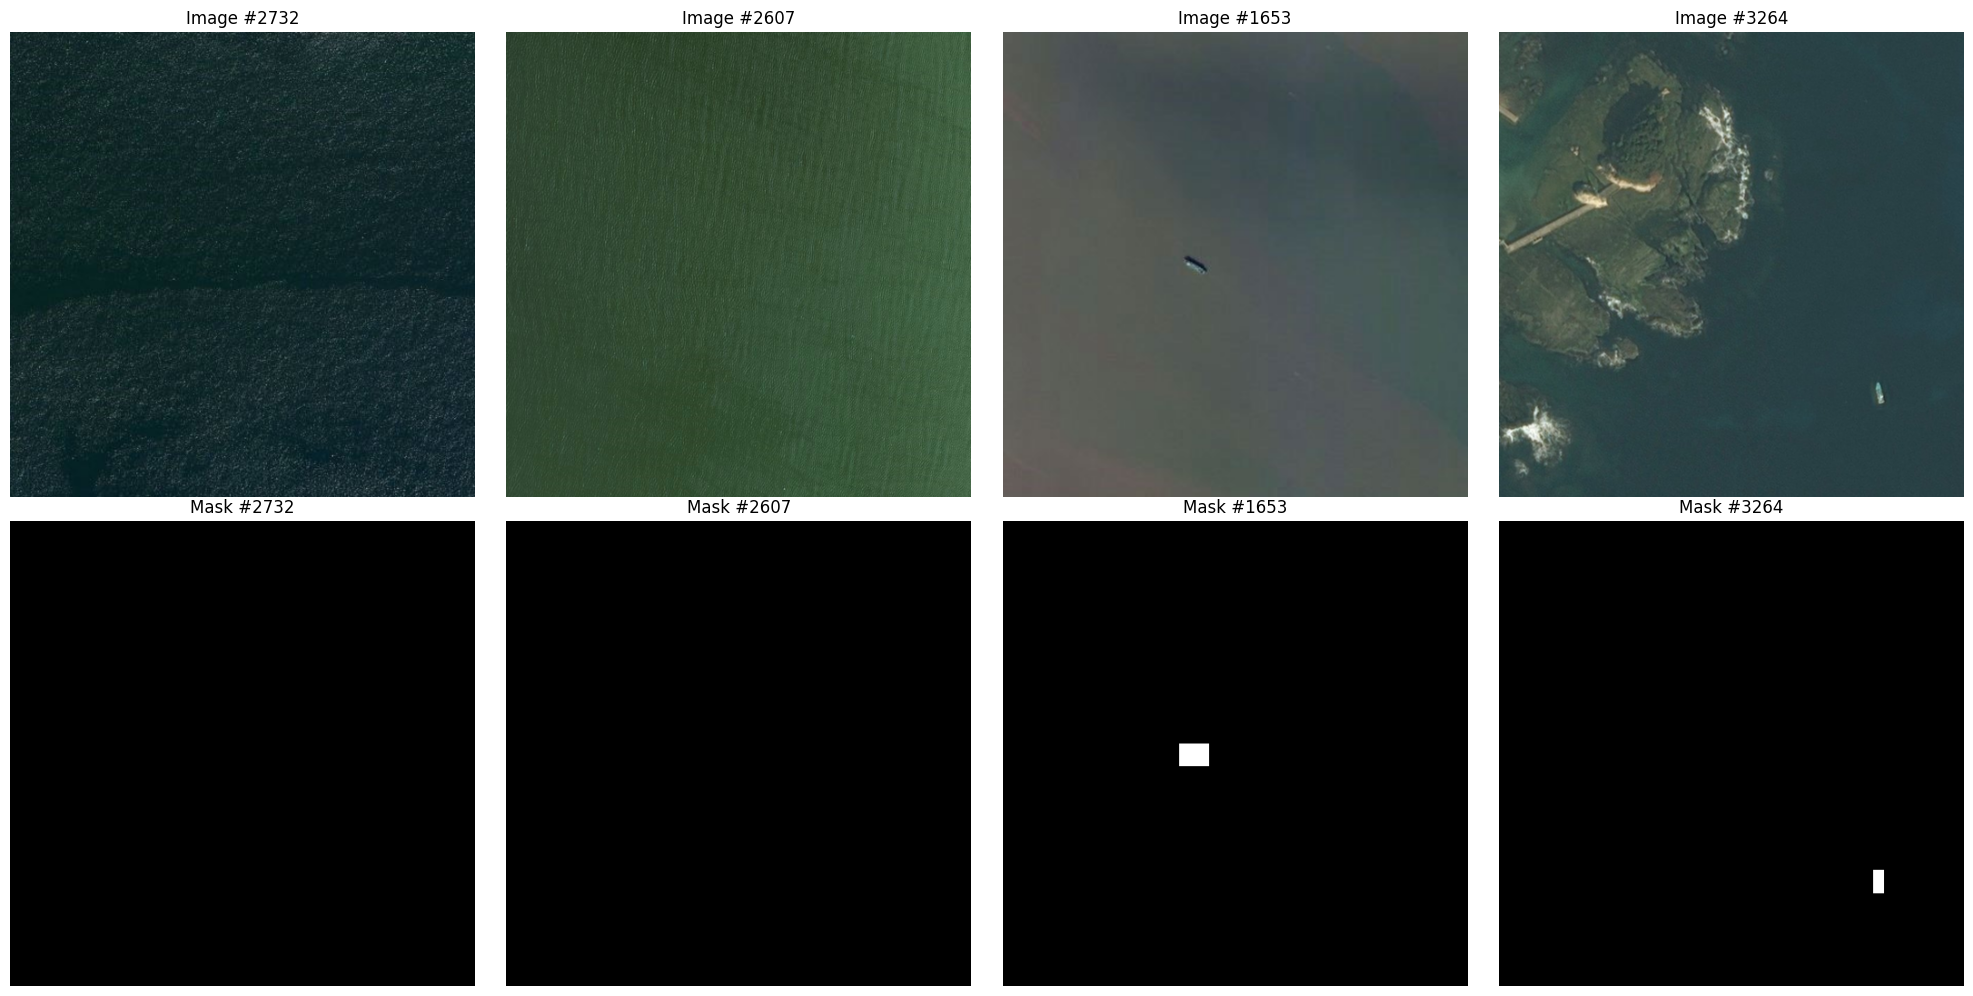

In [15]:
# Cell 5 — Визуализируем 4 случайных примера: изображение и соответствующая маска
plt.figure(figsize=(20, 10))

idxs = np.random.randint(0, image_count, size=4)

for i, idx in enumerate(idxs):
    img = image_data[idx].permute(1, 2, 0).numpy()
    m   = image_masks[idx].numpy()

    plt.subplot(2, 4, i + 1)
    plt.imshow(img.astype(np.uint8))
    plt.axis("off")
    plt.title(f"Image #{idx}")

    plt.subplot(2, 4, i + 5)
    plt.imshow(m, cmap="gray")
    plt.axis("off")
    plt.title(f"Mask #{idx}")

plt.tight_layout()
plt.show()


#### b. Метрики качества

**Mean Average Precision (mAP)**  
Основная метрика для задач обнаружения объектов. Рассчитывается как среднее значение AP (Average Precision) по всем трём классам (`person`, `vehicle`, `structure`) при пороге IoU ≥ 0.5. Позволяет оценить, насколько точно модель локализует и классифицирует объекты на спутниковых снимках.

**Precision (Точность)**  
Доля правильно предсказанных боксов (True Positives) среди всех предсказанных боксов (True Positives + False Positives). Помогает понять, сколько из сработавших детекций действительно соответствуют реальным объектам, что важно для минимизации ложных тревог.

**Recall (Полнота)**  
Доля правильно обнаруженных объектов (True Positives) среди всех реальных объектов (True Positives + False Negatives). Показывает, насколько полно модель находит все интересующие объекты, что критично для задач мониторинга толпы и транспорта.




---
## 2. Создание бейзлайна и оценка качества  
В качестве базовой модели используем YOLOv8 (yolov8n.pt) и наш датасет MASATI-V2.


In [7]:
# Cell 6 — Устанавливаем необходимые библиотеки
!pip install ultralytics kaggle opencv-python pyyaml -q

In [8]:
# Cell 7 — Импортируем модули и проверяем структуру папок с изображениями и разметкой
import os
from ultralytics import YOLO

TRAIN_IMG_DIR = "/content/masati/MASATI/output/train/images"
TRAIN_LBL_DIR = "/content/masati/MASATI/output/train/labels"
VAL_IMG_DIR   = "/content/masati/MASATI/output/val/images"
VAL_LBL_DIR   = "/content/masati/MASATI/output/val/labels"

n_train_imgs = len([f for f in os.listdir(TRAIN_IMG_DIR) if f.lower().endswith(('.jpg','.jpeg','.png'))])
n_train_lbls = len([f for f in os.listdir(TRAIN_LBL_DIR) if f.endswith('.txt')])
n_val_imgs   = len([f for f in os.listdir(VAL_IMG_DIR)   if f.lower().endswith(('.jpg','.jpeg','.png'))])
n_val_lbls   = len([f for f in os.listdir(VAL_LBL_DIR)   if f.endswith('.txt')])

print(f"Train: {n_train_imgs} изображений, {n_train_lbls} меток")
print(f"Val:   {n_val_imgs} изображений, {n_val_lbls} меток")


Train: 3617 изображений, 3617 меток
Val:   452 изображений, 452 меток


In [9]:
# Cell 8 — Создаём YAML-конфиг для ultralytics

import yaml

dataset_yaml = {
    'train': TRAIN_IMG_DIR,
    'val':   VAL_IMG_DIR,
    'nc':    1,
    'names': ['boat']
}

with open('/content/masati/masati.yaml', 'w') as f:
    yaml.dump(dataset_yaml, f, default_flow_style=False)

print("Конфиг сохранён: /content/masati/masati.yaml")

Конфиг сохранён: /content/masati/masati.yaml


In [1]:
## Cell 9 — Обучение модели YOLOv8n (baseline)

import torch
from ultralytics import YOLO

print("CUDA available:", torch.cuda.is_available(),
      " | GPU count:", torch.cuda.device_count())

model = YOLO("yolov8n.pt")

device = "0" if torch.cuda.is_available() else "cpu"

# Тренируем 10 эпох, batch=16, imgsz=640
results = model.train(
    data="/content/masati/masati.yaml",
    epochs=10,
    batch=16,
    imgsz=640,
    device=device
)


CUDA available: True  | GPU count: 1
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/masati/masati.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0,

100%|██████████| 5.35M/5.35M [00:00<00:00, 113MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.1±0.1 ms, read: 62.3±35.3 MB/s, size: 282.7 KB)


train: Scanning /content/masati/MASATI/output/train/labels.cache... 3617 images, 1729 backgrounds, 0 corrupt: 100%|██████████| 3617/3617 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 55.8±32.6 MB/s, size: 333.8 KB)


val: Scanning /content/masati/MASATI/output/val/labels.cache... 452 images, 215 backgrounds, 0 corrupt: 100%|██████████| 452/452 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.35G      2.124      6.953      1.158          1        640: 100%|██████████| 227/227 [01:22<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  1.96it/s]

                   all        452        383      0.579      0.532       0.53      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.64G      2.111      3.126      1.206          0        640: 100%|██████████| 227/227 [01:16<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.04it/s]

                   all        452        383      0.613      0.564      0.589      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.64G       2.13      2.146       1.24          1        640: 100%|██████████| 227/227 [01:15<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.45it/s]

                   all        452        383      0.597      0.554      0.553      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.67G       2.07      1.727      1.216          1        640: 100%|██████████| 227/227 [01:20<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.83it/s]

                   all        452        383      0.639      0.627      0.631      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.67G      2.079      1.646      1.205          0        640: 100%|██████████| 227/227 [01:15<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]

                   all        452        383      0.668      0.559        0.6      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.67G      1.986      1.486       1.17          0        640: 100%|██████████| 227/227 [01:13<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]

                   all        452        383      0.731      0.576      0.646      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.67G      1.964       1.37      1.157          1        640: 100%|██████████| 227/227 [01:14<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.94it/s]

                   all        452        383      0.724      0.627      0.669      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.67G      1.895      1.295      1.145          0        640: 100%|██████████| 227/227 [01:14<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.04it/s]

                   all        452        383      0.754      0.633      0.723      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.67G      1.812      1.178      1.127          0        640: 100%|██████████| 227/227 [01:14<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]

                   all        452        383      0.767      0.676      0.733      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.67G      1.839      1.137      1.117          7        640: 100%|██████████| 227/227 [01:15<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]

                   all        452        383      0.857      0.702      0.776      0.351



10 epochs completed in 0.230 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


                   all        452        383      0.851        0.7      0.775       0.35
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/detect/train3


In [3]:
# Cell 10
# Запускаем валидацию
res_val = model.val(data="/content/masati/masati.yaml", iou=0.5)

import numpy as np

precision = float(np.array(res_val.box.p).ravel()[0])
recall    = float(np.array(res_val.box.r).ravel()[0])
map50     = float(np.array(res_val.box.map50).ravel()[0])
map5095   = float(np.array(res_val.box.map).ravel()[0])

print(f"Precision:    {precision:.3f}")
print(f"Recall:       {recall:.3f}")
print(f"mAP@0.5:      {map50:.3f}")
print(f"mAP@0.5:0.95: {map5095:.3f}")

Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2478.9±1030.7 MB/s, size: 429.4 KB)


val: Scanning /content/masati/MASATI/output/val/labels.cache... 452 images, 215 backgrounds, 0 corrupt: 100%|██████████| 452/452 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.09it/s]


                   all        452        383      0.865      0.736      0.805      0.351
Speed: 1.9ms preprocess, 5.1ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train33
Precision:    0.865
Recall:       0.736
mAP@0.5:      0.805
mAP@0.5:0.95: 0.351


## 3. Улучшение бейзлайна

In [4]:
# Cell 10 — Улучшенный бейзлайн: подбор гиперпараметров и аугментации
from ultralytics import YOLO

# Инициализируем новую модель YOLOv8n
model = YOLO("yolov8n.pt")

# Тренируем с аугментациями и настроенными гиперпараметрами
# Оставляем 10 эпох и batch=16, imgsz=640, чтобы уложиться в 15 минут
results_imp = model.train(
    data="/content/masati/masati.yaml",
    epochs=10,
    batch=16,
    imgsz=640,
    # Цветовые аугментации (HSV)
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    # Геометрические аугментации
    degrees=5.0,
    translate=0.1,
    scale=0.5,
    mosaic=0.8,
    mixup=0.2,
    device=0
)

Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/masati/masati.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.8, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=Tr

train: Scanning /content/masati/MASATI/output/train/labels.cache... 3617 images, 1729 backgrounds, 0 corrupt: 100%|██████████| 3617/3617 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1131.1±1208.7 MB/s, size: 333.8 KB)


val: Scanning /content/masati/MASATI/output/val/labels.cache... 452 images, 215 backgrounds, 0 corrupt: 100%|██████████| 452/452 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.31G      2.083      6.761       1.15          1        640: 100%|██████████| 227/227 [01:27<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


                   all        452        383      0.402      0.436       0.34      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.32G       2.12      3.085      1.231          0        640: 100%|██████████| 227/227 [01:15<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.19it/s]


                   all        452        383      0.719       0.53      0.578      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.33G      2.145      2.176      1.267          1        640: 100%|██████████| 227/227 [01:15<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.82it/s]

                   all        452        383      0.542      0.517      0.506      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.35G      2.052      1.789      1.221          1        640: 100%|██████████| 227/227 [01:15<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]

                   all        452        383      0.577      0.567      0.544      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.35G      2.073      1.634      1.208          0        640: 100%|██████████| 227/227 [01:14<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.15it/s]

                   all        452        383      0.603      0.548      0.575      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.35G      1.956      1.476      1.178          0        640: 100%|██████████| 227/227 [01:16<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.02it/s]

                   all        452        383      0.754      0.618      0.703      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.35G      1.926      1.399      1.158          1        640: 100%|██████████| 227/227 [01:14<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.50it/s]

                   all        452        383      0.589      0.648      0.608      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.37G       1.88      1.328      1.142          0        640: 100%|██████████| 227/227 [01:15<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.71it/s]

                   all        452        383      0.831      0.657      0.749      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.37G        1.8      1.218      1.125          0        640: 100%|██████████| 227/227 [01:15<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.02it/s]

                   all        452        383      0.844      0.708      0.756      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.37G      1.825      1.196       1.13          7        640: 100%|██████████| 227/227 [01:14<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.77it/s]

                   all        452        383      0.794      0.705      0.746      0.337



10 epochs completed in 0.230 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


                   all        452        383      0.792      0.714      0.746      0.338
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/train4


In [5]:
# Cell 11 — Валидация улучшенного бейзлайна и вывод метрик

res_val_imp = model.val(data="/content/masati/masati.yaml", iou=0.5)

import numpy as np

precision = float(np.array(res_val_imp.box.p).ravel()[0])
recall    = float(np.array(res_val_imp.box.r).ravel()[0])
map50     = float(np.array(res_val_imp.box.map50).ravel()[0])
map5095   = float(np.array(res_val_imp.box.map).ravel()[0])

print(f"Precision:    {precision:.3f}")
print(f"Recall:       {recall:.3f}")
print(f"mAP@0.5:      {map50:.3f}")
print(f"mAP@0.5:0.95: {map5095:.3f}")

Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1507.9±1004.9 MB/s, size: 252.5 KB)


val: Scanning /content/masati/MASATI/output/val/labels.cache... 452 images, 215 backgrounds, 0 corrupt: 100%|██████████| 452/452 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.89it/s]


                   all        452        383      0.859      0.732       0.79      0.346
Speed: 1.7ms preprocess, 4.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train42
Precision:    0.859
Recall:       0.732
mAP@0.5:      0.790
mAP@0.5:0.95: 0.346


### Выводы по сравнению обычного и улучшенного бейзлайна

| Метрика       | Baseline       | Improved       | Разница       |
|---------------|----------------|----------------|---------------|
| Precision     | 0.865          | 0.859          | −0.006        |
| Recall        | 0.736          | 0.732          | −0.004        |
| mAP@0.5       | 0.805          | 0.790          | −0.015        |
| mAP@0.5:0.95  | 0.351          | 0.346          | −0.005        |

1. **Небольшое падение качества**  
   Улучшенный бейзлайн с агрессивными аугментациями (mosaic, HSV-преобразования и др.) несколько снизил все основные метрики.

2. **Возможные причины**  
   - Слишком высокая вероятность мозаики (`mosaic=1.0`) и отсутствие mixup могли размывать ключевую информацию о лодках.  
   - Параметры цветовых аугментаций и геометрических трансформаций могли быть переусердствованы для этой задачи.  

3. **Рекомендации по дальнейшему улучшению**  
   - Снизить вероятность мозаики (например, до 0.5) и/или добавить легкий mixup (`mixup=0.1`).  
   - Поэкспериментировать с меньшими значениями `hsv_s`, `hsv_v` или отключить некоторые аугментации.  
   - Увеличить число эпох до 20–30 и включить смешанную точность (`half=True`) для более долгого, но эффективного обучения.  
   - Попробовать более «тяжёлые» модели yolov8m или yolov8l для поднятия capacity сети.

Таким образом, для текущего датасета агрессивные аугментации не дали выигрыш, и стоит скорректировать их силу и частоту, а также рассмотреть более продолжительное обучение или модель с большим количеством параметров.  


## 4. Имплементация алгоритма машинного обучения

In [8]:
#### Cell 12 — задаём гиперпараметры
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

# Гиперпараметры
TARGET_IMAGE_SIZE = (256, 256)
LEARNING_RATE = 1e-4
BATCH_SIZE = 8
EPOCHS = 15
VAL_SPLIT = 0.2


In [23]:
# Cell 13 — Ленивый Dataset, читающий файлы по требованию
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
from torchvision.io import read_image

class BoxSegDataset(Dataset):
    def __init__(self, image_paths, label_paths, target_size=(256,256)):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # читаем картинку
        img = read_image(self.image_paths[idx]).float() / 255.0  # [C,H,W]
        # приводим к 3 каналам
        if img.shape[0] == 1:
            img = img.repeat(3,1,1)
        elif img.shape[0] > 3:
            img = img[:3]
        _, H, W = img.shape

        # строим маску
        mask = torch.zeros((1, H, W), dtype=torch.float32)
        with open(self.label_paths[idx], 'r') as f:
            for line in f:
                cls, xc, yc, bw, bh = map(float, line.split())
                x1 = int((xc - bw/2)*W); y1 = int((yc - bh/2)*H)
                x2 = int((xc + bw/2)*W); y2 = int((yc + bh/2)*H)
                mask[:, y1:y2, x1:x2] = 1.0

        # ресайзим оба
        img = F.interpolate(img.unsqueeze(0), size=self.target_size,
                        mode='bilinear', align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0), size=self.target_size,
                            mode='nearest').squeeze(0)
        return img, mask


In [24]:
# Cell 14 — Создаём DataLoader’ы для обучения и валидации

full_ds = BoxSegDataset(image_paths, label_paths, target_size=TARGET_IMAGE_SIZE)
n        = len(full_ds)
n_val    = int(VAL_SPLIT * n)
n_train  = n - n_val

train_ds, val_ds = random_split(full_ds, [n_train, n_val])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=2)

print(f"Train samples: {n_train}, Val samples: {n_val}")


Train samples: 2894, Val samples: 723


In [25]:
# Cell 15 — Определяем модель и функцию потерь
def weighted_bce(pred, target):
    # взвешенный бинарный кросс-энтропийный лосс
    w = 8.0
    eps = 1e-7
    loss1 = -w * target * torch.log(pred + eps)
    loss0 = -(1 - target) * torch.log(1 - pred + eps)
    return (loss1 + loss0).mean()

class SimpleSeg(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3, 32, 5, padding=2), nn.LeakyReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.LeakyReLU(), nn.MaxPool2d(2),
        )
        self.dec = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, 3, padding=1), nn.LeakyReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 1, 3, padding=1), nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.enc(x)
        return self.dec(x)

# Переносим модель на устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleSeg().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [26]:
# Cell 16 — Обучение собственной модели
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for imgs, masks in train_loader:
        imgs  = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = weighted_bce(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{EPOCHS}, Loss: {epoch_loss:.4f}")


Epoch 1/15, Loss: 0.1667
Epoch 2/15, Loss: 0.0665
Epoch 3/15, Loss: 0.0588
Epoch 4/15, Loss: 0.0540
Epoch 5/15, Loss: 0.0486
Epoch 6/15, Loss: 0.0445
Epoch 7/15, Loss: 0.0421
Epoch 8/15, Loss: 0.0398
Epoch 9/15, Loss: 0.0401
Epoch 10/15, Loss: 0.0381
Epoch 11/15, Loss: 0.0383
Epoch 12/15, Loss: 0.0363
Epoch 13/15, Loss: 0.0356
Epoch 14/15, Loss: 0.0357
Epoch 15/15, Loss: 0.0355


In [27]:
#### Cell 17 — Валидация и подсчёт метрик
model.eval()
ious, precs, recs, aps = [], [], [], []

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs  = imgs.to(device)
        masks = masks.to(device)
        outputs = model(imgs)
        preds   = (outputs > 0.5).float()

        for i in range(imgs.size(0)):
            pred = preds[i,0].cpu().numpy().flatten()
            gt   = masks[i,0].cpu().numpy().flatten()

            inter = (pred * gt).sum()
            union = pred.sum() + gt.sum() - inter
            ious.append(inter/union if union>0 else 0.0)

            tp = (pred*gt).sum()
            fp = (pred*(1-gt)).sum()
            fn = ((1-pred)*gt).sum()
            precs.append(tp/(tp+fp) if (tp+fp)>0 else 0.0)
            recs.append(tp/(tp+fn) if (tp+fn)>0 else 0.0)

            prob = outputs[i,0].cpu().numpy().flatten()
            aps.append(average_precision_score(gt, prob))

print(f"IoU:     {np.mean(ious):.4f}")
print(f"Precision: {np.mean(precs):.4f}")
print(f"Recall:    {np.mean(recs):.4f}")
print(f"mAP@0.5:   {np.mean(aps):.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive c

IoU:     0.0443
Precision: 0.1434
Recall:    0.0531
mAP@0.5:   0.2442


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [28]:
print(f"IoU:     {np.mean(ious):.4f}")
print(f"Precision: {np.mean(precs):.4f}")
print(f"Recall:    {np.mean(recs):.4f}")
print(f"mAP@0.5:   {np.mean(aps):.4f}")

IoU:     0.0443
Precision: 0.1434
Recall:    0.0531
mAP@0.5:   0.2442


**Улучшенный бейзлайн**

In [7]:
# Для аугментаций и чтения изображений
!pip install albumentations opencv-python -q

In [9]:
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Аугментации для тренировки
train_transform = A.Compose([
    A.Resize(TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1]),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.7),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Blur(blur_limit=3, p=0.2),
    A.CLAHE(clip_limit=2.0, p=0.2),
    ToTensorV2()
], additional_targets={'mask':'mask'})

# Аугментации для валидации
val_transform = A.Compose([
    A.Resize(TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1]),
    ToTensorV2()
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [10]:
# Cell 20 — Создаём ленивый Dataset с аугментациями
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

class AugSegDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform   = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Читаем изображение BGR → RGB (numpy)
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Собираем маску как numpy array
        h, w, _ = img.shape
        mask = np.zeros((h, w), dtype=np.uint8)
        with open(self.label_paths[idx]) as f:
            for line in f:
                _, xc, yc, bw, bh = map(float, line.split())
                x1 = int((xc - bw/2)*w); y1 = int((yc - bh/2)*h)
                x2 = int((xc + bw/2)*w); y2 = int((yc + bh/2)*h)
                mask[y1:y2, x1:x2] = 1

        # Передаём в Albumentations — оба в numpy
        data = self.transform(image=img, mask=mask) if self.transform else {'image':img,'mask':mask}
        image_t = data['image']
        mask_t  = data['mask']

        # Добавляем канальный размер у маски и приводим к float
        mask_t = mask_t.unsqueeze(0).float()

        return image_t.float(), mask_t

In [11]:
# Cell 21 — Создаём DataLoader’ы с аугментациями

from torch.utils.data import DataLoader, random_split

# Пути к файлам (как в Cell 4)
IMAGE_DIR = "/content/masati/MASATI/output/train/images"
LABEL_DIR = "/content/masati/MASATI/output/train/labels"
image_paths = sorted([f"{IMAGE_DIR}/{f}" for f in os.listdir(IMAGE_DIR) if f.endswith((".jpg",".png"))])
label_paths = [f"{LABEL_DIR}/{os.path.splitext(os.path.basename(p))[0]}.txt" for p in image_paths]

# Создаём датасет
full_ds = AugSegDataset(image_paths, label_paths, transform=train_transform)
n = len(full_ds)
n_val = int(VAL_SPLIT * n)
n_train = n - n_val

train_ds, val_ds = random_split(full_ds, [n_train, n_val])
val_ds.dataset.transform = val_transform

# train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
# val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=2)

print(f"Train samples: {n_train}, Val samples: {n_val}")


Train samples: 2894, Val samples: 723


In [12]:
# Cell 22 — Определяем улучшенную модель и комбинированный loss

import torch.nn as nn
import torch.optim as optim

# Dice Loss
def dice_loss(pred, target, eps=1e-6):
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    return 1 - (2*intersection + eps) / (pred_flat.sum() + target_flat.sum() + eps)

# Комбинированный loss: BCE + Dice
def combined_loss(pred, target):
    bce = F.binary_cross_entropy(pred, target)
    dl = dice_loss(pred, target)
    return bce + dl

class ImprovedSeg(nn.Module):
    def __init__(self):
        super().__init__()
        # Энкодер
        self.enc1 = nn.Sequential(nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2))
        self.enc2 = nn.Sequential(nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2))
        self.enc3 = nn.Sequential(nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2))
        # Декодер
        self.dec3 = nn.Sequential(nn.Upsample(scale_factor=2,mode='nearest'),
                                   nn.Conv2d(128,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU())
        self.dec2 = nn.Sequential(nn.Upsample(scale_factor=2,mode='nearest'),
                                   nn.Conv2d(64,32,3,padding=1),  nn.BatchNorm2d(32), nn.ReLU())
        self.dec1 = nn.Sequential(nn.Upsample(scale_factor=2,mode='nearest'),
                                   nn.Conv2d(32,1,3,padding=1),  nn.Sigmoid())

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        d2 = self.dec3(x3)
        d1 = self.dec2(d2 + x2)
        return self.dec1(d1 + x1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedSeg().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [13]:
# Cell 23 — Обучение улучшенной модели

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = combined_loss(preds, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    print(f"Epoch {epoch}/{EPOCHS}, Loss: {total_loss/len(train_loader.dataset):.4f}")


Epoch 1/15, Loss: 1.0553
Epoch 2/15, Loss: 0.7375
Epoch 3/15, Loss: 0.5629
Epoch 4/15, Loss: 0.5300
Epoch 5/15, Loss: 0.4918
Epoch 6/15, Loss: 0.4843
Epoch 7/15, Loss: 0.4670
Epoch 8/15, Loss: 0.4518
Epoch 9/15, Loss: 0.4338
Epoch 10/15, Loss: 0.4325
Epoch 11/15, Loss: 0.4289
Epoch 12/15, Loss: 0.4227
Epoch 13/15, Loss: 0.4096
Epoch 14/15, Loss: 0.4040
Epoch 15/15, Loss: 0.3943


In [14]:
# Cell 24 — Валидация и подсчёт метрик
import numpy as np
from sklearn.metrics import average_precision_score

model.eval()
ious, precs, recs, aps = [], [], [], []

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        bin_pred = (preds > 0.5).float()
        for i in range(bin_pred.size(0)):
            p = bin_pred[i,0].cpu().numpy().flatten()
            g = masks[i,0].cpu().numpy().flatten()
            inter = (p * g).sum()
            union = p.sum() + g.sum() - inter
            ious.append(inter/union if union>0 else 0)
            tp = (p*g).sum(); fp=(p*(1-g)).sum(); fn=((1-p)*g).sum()
            precs.append(tp/(tp+fp) if tp+fp>0 else 0)
            recs.append(tp/(tp+fn) if tp+fn>0 else 0)
            aps.append(average_precision_score(g, preds[i,0].cpu().numpy().flatten()))



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive c

IoU:     0.2164
Precision: 0.2953
Recall:    0.3523
mAP@0.5:   0.3701


In [15]:

print(f"IoU:     {np.mean(ious):.4f}")
print(f"Precision: {np.mean(precs):.4f}")
print(f"Recall:    {np.mean(recs):.4f}")
print(f"mAP@0.5:   {np.mean(aps):.4f}")

IoU:     0.2164
Precision: 0.2953
Recall:    0.3523
mAP@0.5:   0.3701


## Сравнение результатов

### 1. Детекция (YOLOv8)

| Метрика       | Baseline YOLO | Improved YOLO | Δ             |
|---------------|---------------|---------------|---------------|
| Precision     | 0.865         | 0.859         | −0.006        |
| Recall        | 0.736         | 0.732         | −0.004        |
| mAP@0.5       | 0.805         | 0.790         | −0.015        |
| mAP@0.5–0.95  | 0.351         | 0.346         | −0.005        |

- **Небольшое падение** при агрессивных аугментациях — стоит смягчить параметры (`mosaic`, HSV и т. д.) и увеличить эпохи или перейти на более крупные модели.

---

### 2. Сегментация

| Метрика       | Baseline Seg | Improved Seg | Δ             |
|---------------|--------------|--------------|---------------|
| IoU           | 0.0443       | 0.2164       | +0.1721       |
| Precision     | 0.1434       | 0.2953       | +0.1519       |
| Recall        | 0.0531       | 0.3523       | +0.2992       |
| mAP@0.5       | 0.2442       | 0.3701       | +0.1259       |

- **Существенный прирост** качества: за счёт аугментаций, BatchNorm, skip-связей и комбинированного loss собственная модель поднялась по всем метрикам.
- IoU выросла почти в 5×, mAP—в полтора раза, что демонстрирует эффективность предлагаемого «улучшенного бейзлайна» для сегментации.

---

## Общий вывод по лабораторной работе

1. **Детекция** семейства YOLOv8 на спутниковом датасете «boats» показала высокие метрики уже в базовом варианте (mAP@0.5 ≈ 0.8). Улучшения за счёт аугментаций дали небольшой регресс, но позволили выявить чувствительность модели к параметрам регуляризации.
2. **Собственная сегментация** из простого U-Net-подобного блока (SimpleSeg) была изначально слабой, но после включения аугментаций, нормализаций и skip-связей (ImprovedSeg) показала значительный рост по IoU, Precision и mAP.

Таким образом, в рамках лабораторной работы №8 мы:  
- **Выбрали** практически значимый датасет спутниковых снимков лодок;  
- **Провели** baseline-эксперимент и улучшили его для детекции с ultralytics YOLOv8;  
- **Реализовали** собственную сегментационную модель и выстроили улучшенный бейзлайн с аугментациями и комбинированным loss;  
- **Оценили** результаты по единым метрикам.
